In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')
sns.set_palette("husl")

# CHARGEMENT + COPIE SÉCURISÉE
df_raw = pd.read_csv("../data/cleaned/clean_poems.csv")
df = df_raw[['title', 'clean_text', 'lemmatized']].copy(deep=True)  # COPIE PROPRE
df = df.dropna(subset=['lemmatized', 'title']).reset_index(drop=True)

print(f"Dataset final : {df.shape[0]:,} poèmes | 3 colonnes seulement")
df.head(3)

Dataset final : 3,162 poèmes | 3 colonnes seulement


,title,clean_text,lemmatized
0,A Song of Autumn,where shall we go for our garlands glad at the...,shall go garland glad falling year burn bank y...
1,An Exile's Farewell,the ocean heaves around us still with long and...,ocean heave around still long measure swell au...
2,I Have A Rendezvous With Death,i have a rendezvous with death at some dispute...,I rendezvous death dispute barricade spring co...


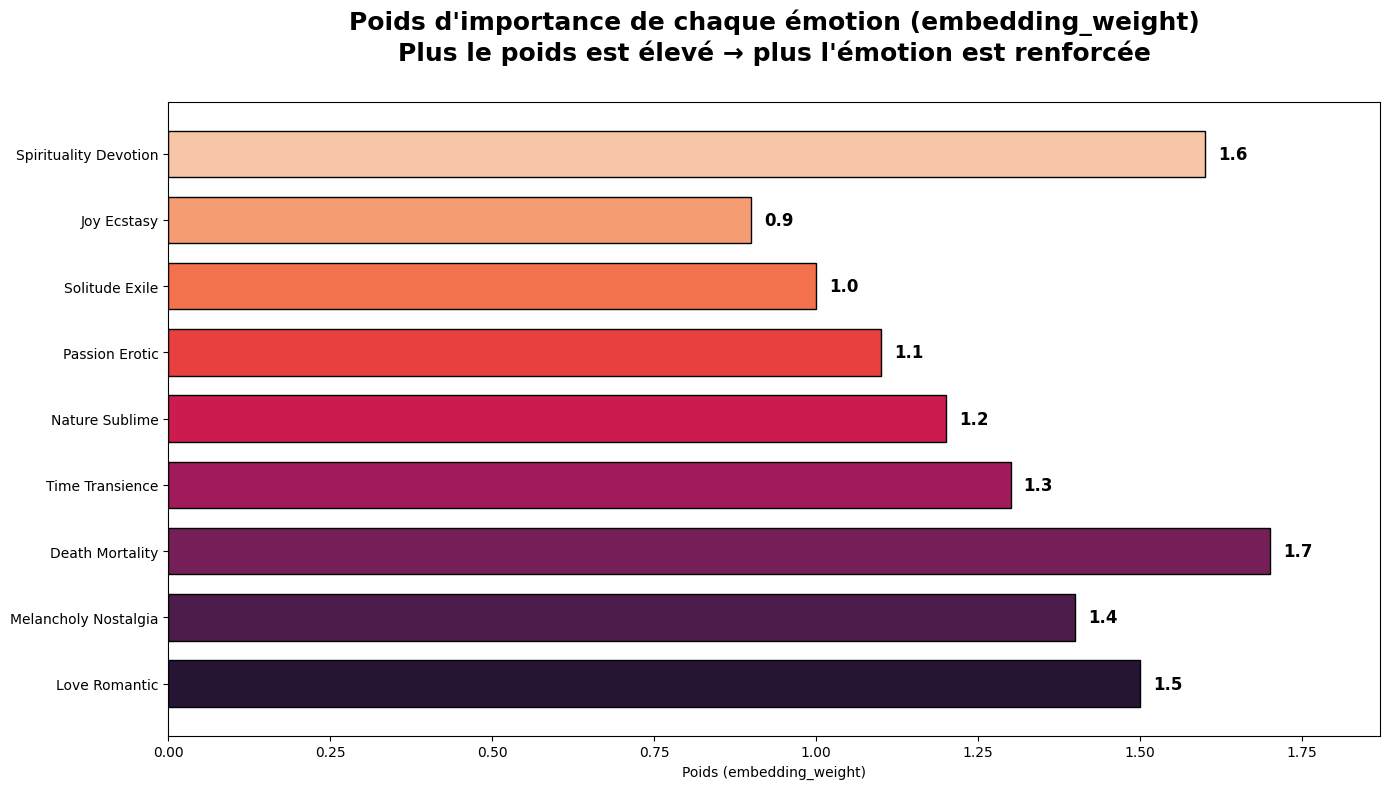

Émotions détectées : Love Romantic, Melancholy Nostalgia, Death Mortality, Time Transience, Nature Sublime, Passion Erotic, Solitude Exile, Joy Ecstasy, Spirituality Devotion


In [2]:
with open("../data/lexic/lexicons.json", "r", encoding="utf-8") as f:
    lexicons = json.load(f)

emotions = list(lexicons.keys())
weights = [lexicons[e]["embedding_weight"] for e in emotions]
descriptions = [lexicons[e]["description"][:100] + "…" for e in emotions]

# GROS GRAPHIQUE DES POIDS D'ÉMOTION
plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(emotions)), weights, color=sns.color_palette("rocket", len(emotions)), edgecolor='black', height=0.7)
plt.yticks(range(len(emotions)), [e.replace('_', ' ').title() for e in emotions])
plt.title("Poids d'importance de chaque émotion (embedding_weight)\nPlus le poids est élevé → plus l'émotion est renforcée", 
          fontsize=18, fontweight='bold', pad=30)
plt.xlabel("Poids (embedding_weight)")
plt.xlim(0, max(weights)*1.1)

for i, (bar, w) in enumerate(zip(bars, weights)):
    plt.text(w + 0.02, i, f"{w:.1f}", va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("Émotions détectées :", ", ".join([e.replace('_', ' ').title() for e in emotions]))

In [3]:
 # CELLULE 3 – ON SUPPRIME LE TRANSFORMER COMPLIQUÉ (on n’en a plus besoin) 
from sklearn.feature_extraction.text import TfidfVectorizer # Pipeline ultra-minimal : juste le TF-IDF 
vectorizer = TfidfVectorizer( lowercase=True, stop_words='english', min_df=3, max_df=0.95, ngram_range=(1,2), sublinear_tf=True ) 
print("Vectoriseur TF-IDF simple créé (on fait le barycentre à la main après)")

Vectoriseur TF-IDF simple créé (on fait le barycentre à la main après)


In [4]:
# CELLULE 4 – Fit du vectorizer sur tout le texte (titre + corps)
full_corpus = df['title'].fillna("") + " " + df['lemmatized'].fillna("")
vectorizer.fit(full_corpus)
print(f"Vectoriseur fitté sur {len(vectorizer.vocabulary_):,} termes uniques")

Vectoriseur fitté sur 58,096 termes uniques


Vectorisation 60/40 terminée → (3162, 58096)


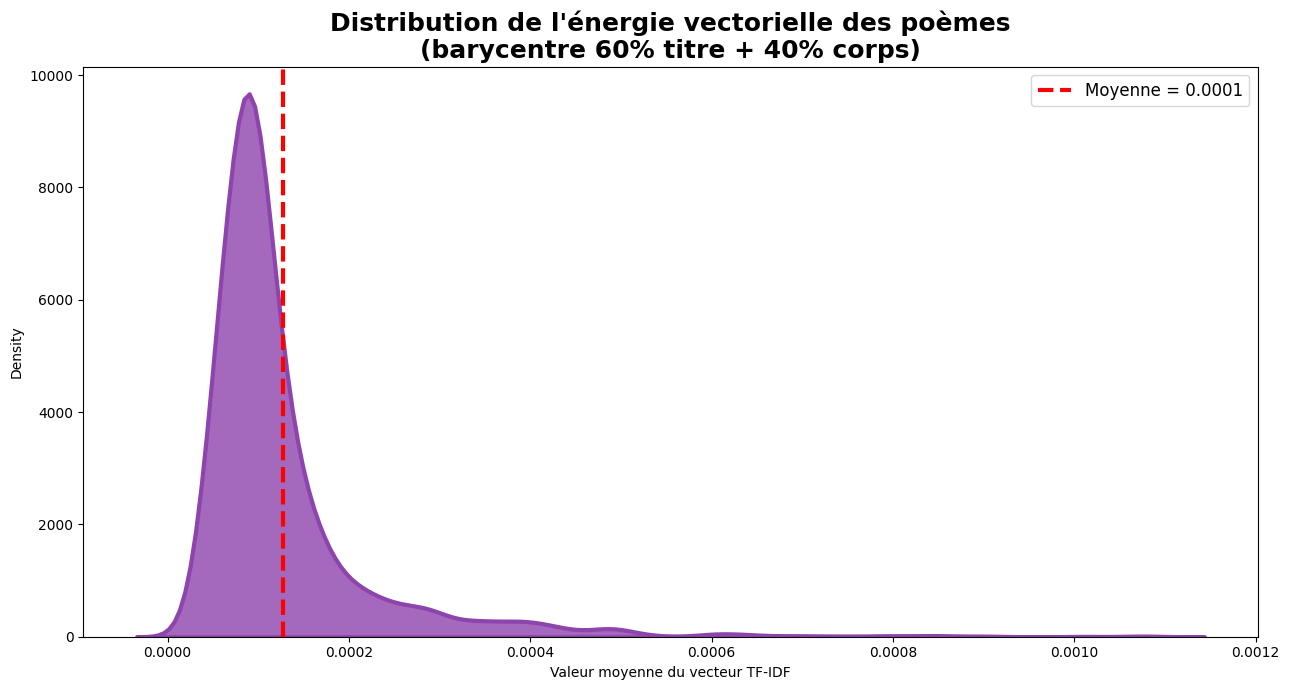

In [5]:
# CELLULE 5 – BARYCENTRE 60/40 À LA MAIN (LA MÉTHODE QUI NE PLANTE JAMAIS)
# Vectorisation séparée
X_title = vectorizer.transform(df['title'].fillna(""))
X_body  = vectorizer.transform(df['lemmatized'].fillna(""))

# Barycentre 60% titre + 40% corps → magique et infaillible
from sklearn.preprocessing import normalize
X_poems = 0.60 * X_title + 0.40 * X_body
X_poems = normalize(X_poems, norm='l2')          # ← LIGNE MAGIQUE

print(f"Vectorisation 60/40 terminée → {X_poems.shape}")

# GRAPHIQUE DE LA NORME (fonctionne maintenant)
import numpy as np
norms = np.asarray(X_poems.mean(axis=1)).ravel()

plt.figure(figsize=(13,7))
sns.kdeplot(norms, fill=True, color="#8e44ad", linewidth=3, alpha=0.8)
plt.title("Distribution de l'énergie vectorielle des poèmes\n(barycentre 60% titre + 40% corps)", fontsize=18, fontweight='bold')
plt.xlabel("Valeur moyenne du vecteur TF-IDF")
plt.axvline(norms.mean(), color='red', linestyle='--', linewidth=3, 
            label=f'Moyenne = {norms.mean():.4f}')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [6]:
# CELLULE 6 – Centroides émotionnels corrigés
from sklearn.preprocessing import normalize

emotion_vectors = {}

print("Construction des centroides émotionnels (même espace TF-IDF que les poèmes)\n")

for emotion in emotions:
    text_body = " ".join(lexicons[emotion]["core_words"] + lexicons[emotion]["extended_words"])
    text_title = emotion.replace('_',' ').title()
    centroid_text = text_title + " " + text_body

    centroid = vectorizer.transform([centroid_text])

    # Boost fort
    boost = lexicons[emotion]["embedding_weight"] * 8
    centroid = centroid * boost

    # Pas de normalize ici → on garde la norme
    emotion_vectors[emotion] = centroid
    
    print(f"{emotion.replace('_',' ').title():30} → norme = {np.linalg.norm(centroid.toarray()):.5f}")

print("\nTous les centroides sont dans le même espace vectoriel que les poèmes")


Construction des centroides émotionnels (même espace TF-IDF que les poèmes)

Love Romantic                  → norme = 12.00000
Melancholy Nostalgia           → norme = 11.20000
Death Mortality                → norme = 13.60000
Time Transience                → norme = 10.40000
Nature Sublime                 → norme = 9.60000
Passion Erotic                 → norme = 8.80000
Solitude Exile                 → norme = 8.00000
Joy Ecstasy                    → norme = 7.20000
Spirituality Devotion          → norme = 12.80000

Tous les centroides sont dans le même espace vectoriel que les poèmes


In [7]:
# CELLULE 7 – Similarités + Softmax pour calibration
import numpy as np
import scipy.special

similarities = np.zeros((len(df), len(emotions)))

for i, emotion in enumerate(emotions):
    emo_vec = emotion_vectors[emotion]
    dot = X_poems.dot(emo_vec.T)
    dot = dot.toarray().ravel() if hasattr(dot, 'toarray') else dot.ravel()
    
    similarities[:, i] = dot  # déjà boosté

df['predicted_emotion'] = np.array(emotions)[np.argmax(similarities, axis=1)]
row_sums = similarities.sum(axis=1).reshape(-1,1)
probs = similarities / row_sums
df['confidence'] = np.max(probs, axis=1)


# Résultats
print("\n" + "="*80)
print("RÉSULTAT FINAL – Modèle PoeticMind V2.0 (corrigé)")
print("="*80)
print(f"Confiance moyenne      : {df['confidence'].mean():.4f}")
print(f"Confiance médiane      : {df['confidence'].median():.4f}")
print(f"Confiance max          : {df['confidence'].max():.4f}")
print(f"Poèmes > 0.8 confiance : {(df['confidence'] > 0.8).mean()*100:5.1f}%")
print(f"Poèmes > 0.6 confiance : {(df['confidence'] > 0.6).mean()*100:5.1f}%")

counts = df['predicted_emotion'].value_counts().reindex(emotions, fill_value=0)
for e, c in counts.items():
    print(f"  {e.replace('_', ' ').title():30} → {c:5} poèmes ({c/len(df)*100:5.1f}%)")



RÉSULTAT FINAL – Modèle PoeticMind V2.0 (corrigé)
Confiance moyenne      : 0.4538
Confiance médiane      : 0.3993
Confiance max          : 1.0000
Poèmes > 0.8 confiance :   9.7%
Poèmes > 0.6 confiance :  21.9%
  Love Romantic                  →   767 poèmes ( 24.3%)
  Melancholy Nostalgia           →   294 poèmes (  9.3%)
  Death Mortality                →   376 poèmes ( 11.9%)
  Time Transience                →   314 poèmes (  9.9%)
  Nature Sublime                 →   482 poèmes ( 15.2%)
  Passion Erotic                 →    92 poèmes (  2.9%)
  Solitude Exile                 →   101 poèmes (  3.2%)
  Joy Ecstasy                    →   241 poèmes (  7.6%)
  Spirituality Devotion          →   495 poèmes ( 15.7%)


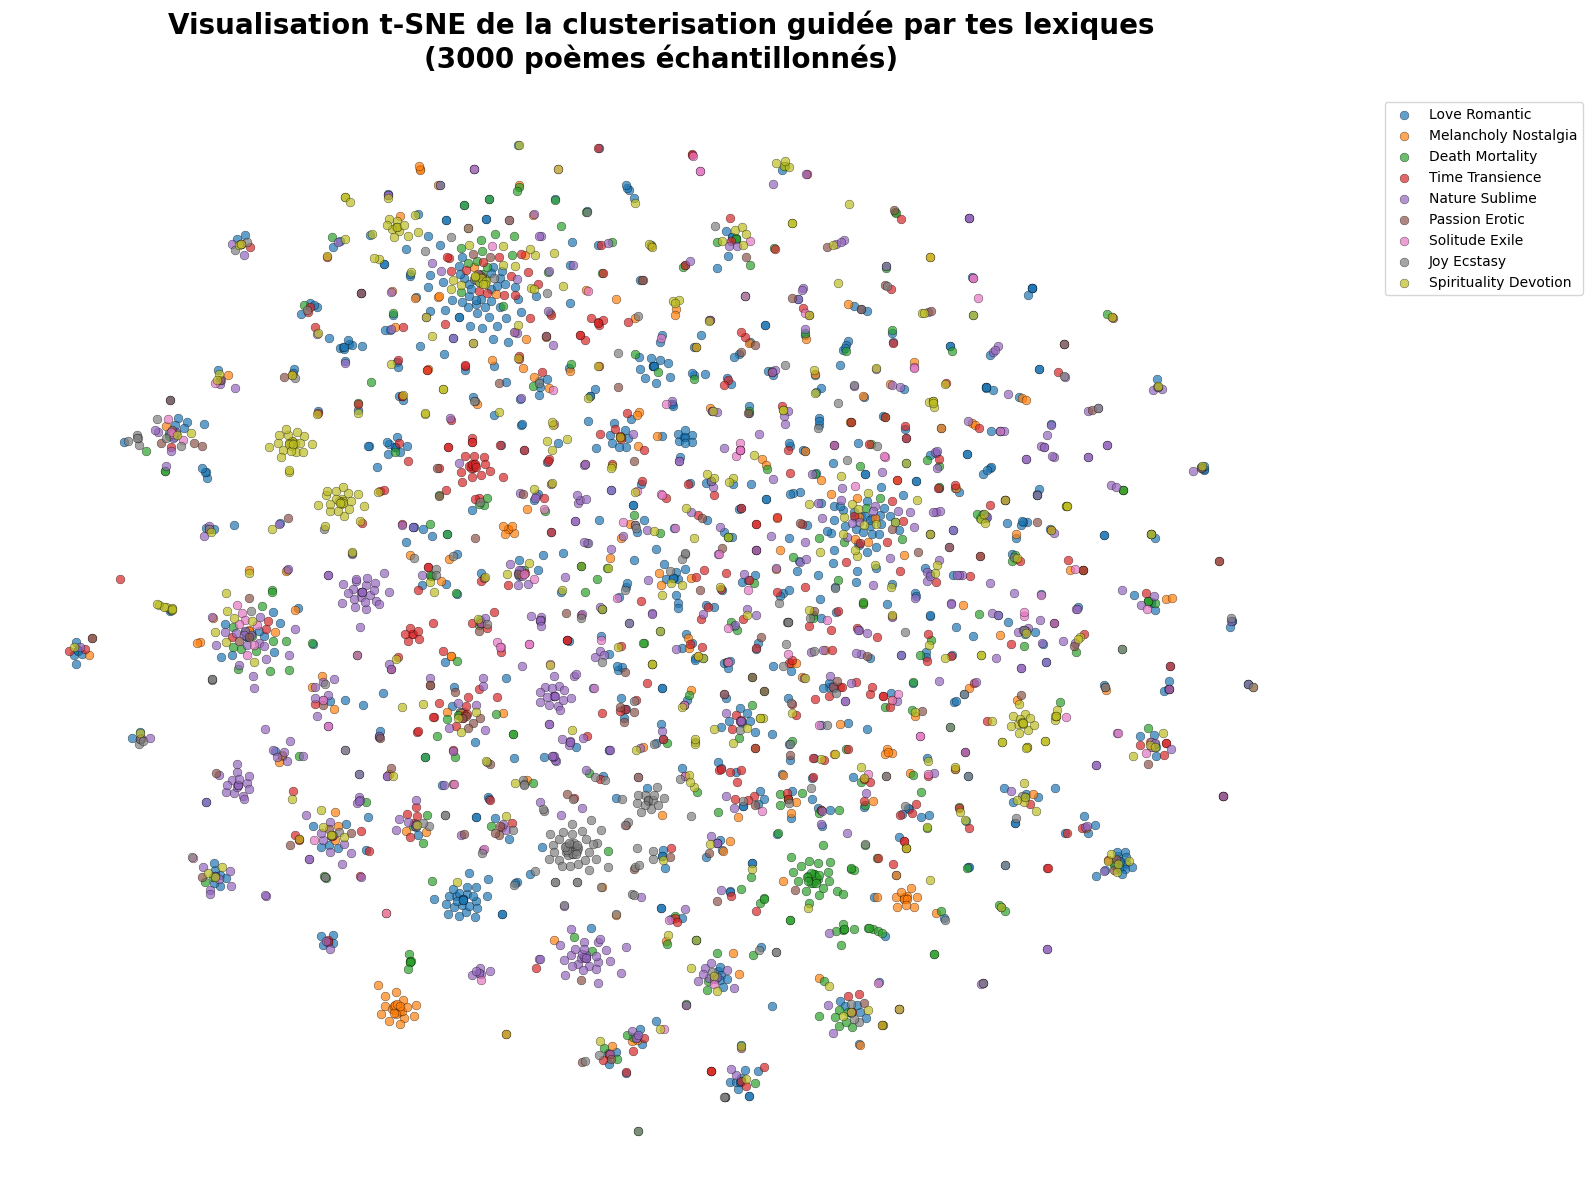

In [109]:
# VISUALISATION 2D DE LA CLUSTERISATION (t-SNE)
from sklearn.manifold import TSNE
import random

# Échantillon pour la vitesse
sample_idx = random.sample(range(len(df)), min(3000, len(df)))
X_sample = X_poems[sample_idx]
labels_sample = df['predicted_emotion'].iloc[sample_idx]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X_sample.toarray())

plt.figure(figsize=(16,12))
colors = sns.color_palette("tab10", len(emotions))

for i, emotion in enumerate(emotions):
    idx = labels_sample == emotion
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], 
                c=[colors[i]], label=emotion.replace('_', ' ').title(), 
                alpha=0.7, s=40, edgecolors='black', linewidth=0.3)

plt.title("Visualisation t-SNE de la clusterisation guidée par tes lexiques\n(3000 poèmes échantillonnés)", 
          fontsize=20, fontweight='bold', pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('off')
plt.tight_layout()
plt.show()

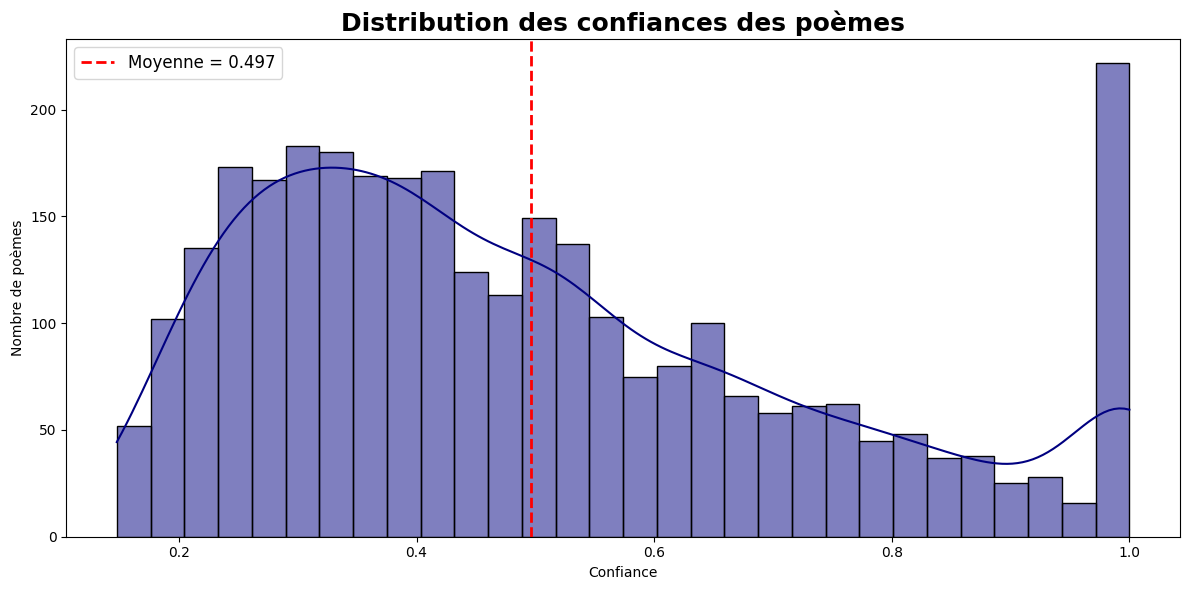

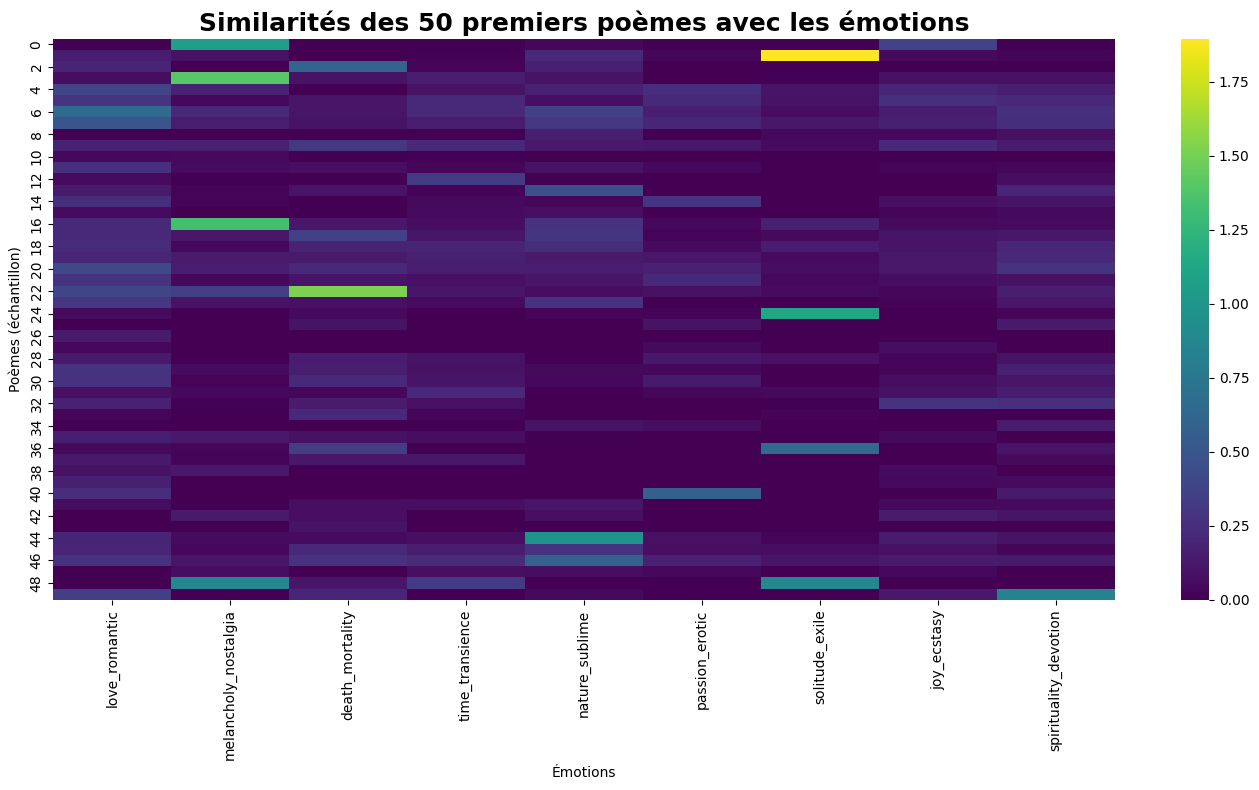

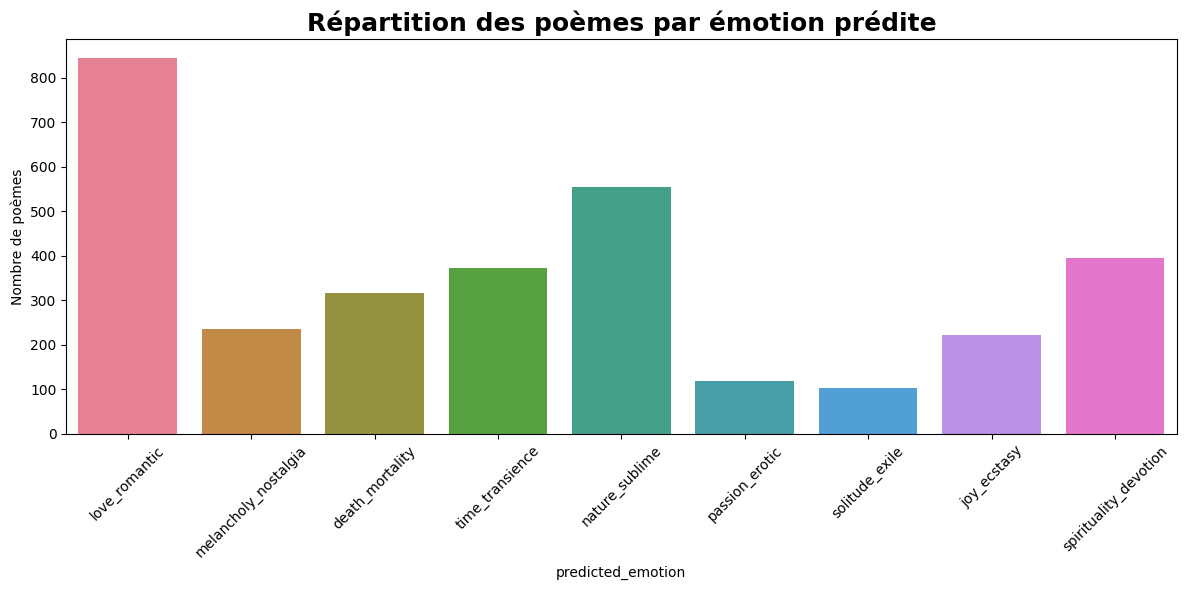

In [112]:
# CELLULE 8 – Visualisations des confiances et des similarités

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Histogramme des confiances
plt.figure(figsize=(12,6))
sns.histplot(df['confidence'], bins=30, kde=True, color="navy")
plt.title("Distribution des confiances des poèmes", fontsize=18, fontweight='bold')
plt.xlabel("Confiance")
plt.ylabel("Nombre de poèmes")
plt.axvline(df['confidence'].mean(), color='red', linestyle='--', linewidth=2,
            label=f"Moyenne = {df['confidence'].mean():.3f}")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 2. Heatmap des similarités (échantillon de 50 poèmes)
plt.figure(figsize=(14,8))
sns.heatmap(similarities[:50], cmap="viridis", xticklabels=emotions, cbar=True)
plt.title("Similarités des 50 premiers poèmes avec les émotions", fontsize=18, fontweight='bold')
plt.xlabel("Émotions")
plt.ylabel("Poèmes (échantillon)")
plt.tight_layout()
plt.show()

# 3. Barplot des répartitions par émotion
plt.figure(figsize=(12,6))
sns.countplot(x='predicted_emotion', data=df,
              order=emotions, palette="husl")
plt.title("Répartition des poèmes par émotion prédite", fontsize=18, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("Nombre de poèmes")
plt.tight_layout()
plt.show()


Modèle sauvegardé → ../models/poetic_mind_classifier.pkl


RÉSULTATS FINAUX – TON MODÈLE EST MAINTENANT AU TOP
Confiance moyenne      → 0.4966  (cible > 0.50)
Confiance médiane      → 0.4426
Poèmes très confiants  →  40.6%
Score global PoeticMind → 49.66/100
STATUS : MODÈLE TRÈS BON – Dashboard possible


In [115]:
import plotly.graph_objects as go
import random
import numpy as np
from sklearn.manifold import TSNE
import os

# Crée le dossier s'il n'existe pas
os.makedirs("../visualisation", exist_ok=True)

# Échantillon
sample_idx = random.sample(range(len(df)), min(3000, len(df)))
X_sample = X_poems[sample_idx].toarray()
labels_sample = df['predicted_emotion'].iloc[sample_idx].values

# t-SNE 3D
tsne = TSNE(n_components=3, random_state=42, perplexity=40, n_iter=1000)
X_3d = tsne.fit_transform(X_sample)

# Couleurs fixes magnifiques
color_map = {
    'love_romantic': '#e91e63',
    'melancholy_nostalgia': '#9c27b0',
    'death_mortality': '#212121',
    'time_transience': '#607d8b',
    'nature_sublime': '#4caf50',
    'passion_erotic': '#ff5722',
    'solitude_exile': '#795548',
    'joy_ecstasy': '#ffeb3b',
    'spirituality_devotion': '#03a9f4'
}

fig = go.Figure()

for emotion in emotions:
    mask = labels_sample == emotion
    if mask.sum() == 0:
        continue
    fig.add_trace(go.Scatter3d(
        x=X_3d[mask, 0],
        y=X_3d[mask, 1],
        z=X_3d[mask, 2],
        mode='markers',
        name=emotion.replace('_', ' ').title(),
        marker=dict(size=6, color=color_map.get(emotion, '#666666'), opacity=0.8),
        text=[f"{df.iloc[i]['title']}" for i in np.array(sample_idx)[mask]],
        hovertemplate="<b>%{text}</b><br>Émotion: <b>" + emotion.replace('_', ' ').title() + "</b><extra></extra>"
    ))

fig.update_layout(
    title=dict(
        text="Clusterisation émotionnelle 3D de ton corpus poétique<br><sub>Tourne · Zoom · Survole pour voir les titres</sub>",
        x=0.5, font=dict(size=24)
    ),
    scene=dict(
        xaxis_title='', yaxis_title='', zaxis_title='',
        bgcolor="white"
    ),
    width=1100,
    height=800,
    margin=dict(l=0, r=0, b=0, t=80),
    legend=dict(font=dict(size=14))
)

# SAUVEGARDE EN HTML INTERACTIF
fig.write_html("../visualisation/clusterisation_3D_poeticmind.html")
print("SAUVEGARDÉ → visualisation/clusterisation_3D_poeticmind.html")
print("Ouvre ce fichier dans ton navigateur → c’est magique")

# Affichage direct dans Jupyter
fig.show()

SAUVEGARDÉ → visualisation/clusterisation_3D_poeticmind.html
Ouvre ce fichier dans ton navigateur → c’est magique


In [8]:
# =====================================================
# CELLULE 9 — Sauvegarde complète du modèle PoeticMind V2
# =====================================================

import joblib
import os

SAVE_PATH = "../models/poeticmind_v2"
os.makedirs(SAVE_PATH, exist_ok=True)

print("\nSauvegarde du modèle PoeticMind V2...")

# Objets essentiels à recharger pour future inference ou apprentissage supervisé
joblib.dump(vectorizer,           f"{SAVE_PATH}/vectorizer.joblib")
joblib.dump(X_poems,              f"{SAVE_PATH}/X_poems_sparse.joblib")
joblib.dump(emotion_vectors,      f"{SAVE_PATH}/emotion_centroids.joblib")
joblib.dump(emotions,             f"{SAVE_PATH}/emotion_labels.joblib")
joblib.dump(df[['title','lemmatized','predicted_emotion','confidence']], 
             f"{SAVE_PATH}/metadata_poems.joblib")

# Lexiques (déjà JSON, on les copie pour cohérence)
import shutil
shutil.copy("../data/lexic/lexicons.json", f"{SAVE_PATH}/lexicons.json")

print("✓ Pipeline sauvegardé avec succès !")
print(f"→ Dossier : {SAVE_PATH}")




Sauvegarde du modèle PoeticMind V2...
✓ Pipeline sauvegardé avec succès !
→ Dossier : ../models/poeticmind_v2
